In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
transactions_im = pd.read_csv('transactions_cluster1.csv', header=0)

In [3]:
transactions = transactions_im.fillna(0)

In [4]:
transactions['date'] = pd.to_datetime(transactions['date'], format = '%Y-%m-%d')
transactions = transactions.set_index('date')

In [5]:
ts = transactions.mean(axis=1)
ts.head()

date
2017-04-20    1228.541667
2017-04-21    1284.500000
2017-04-22    1427.333333
2017-04-23    1399.958333
2017-04-24    1249.500000
dtype: float64

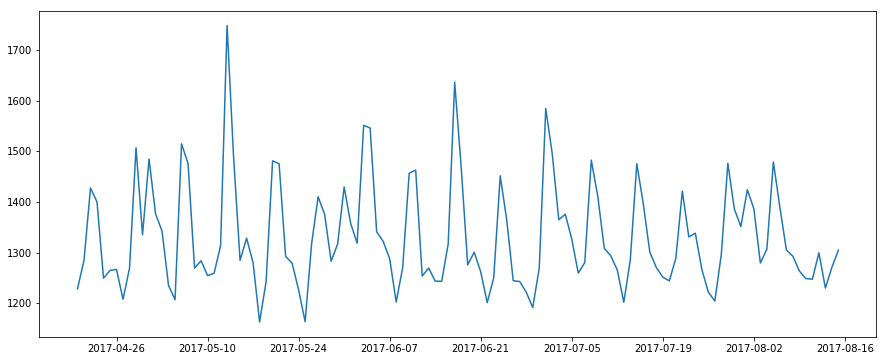

In [6]:
plt.plot(ts.index.to_pydatetime(), ts.values)

In [7]:
#ts_week = ts.resample('W').mean()

In [8]:
#plt.plot(ts_week.index.to_pydatetime(), ts_week.values)

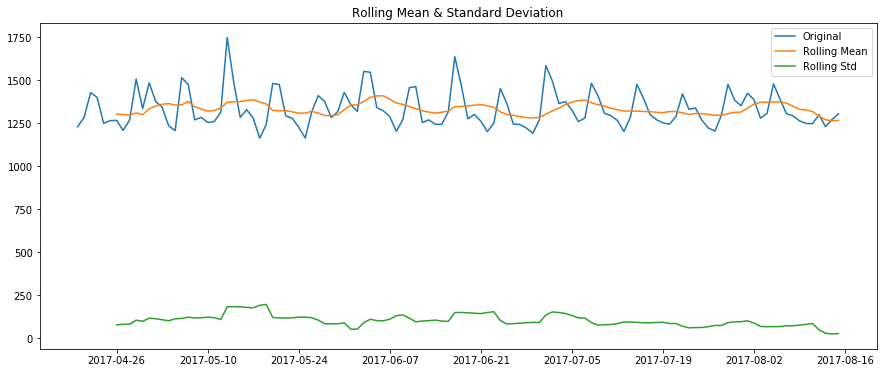

In [9]:
rolmean = ts.rolling(window=7).mean()
rolstd = ts.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=10)
    rolstd = pd.rolling_std(timeseries, window=10)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  """


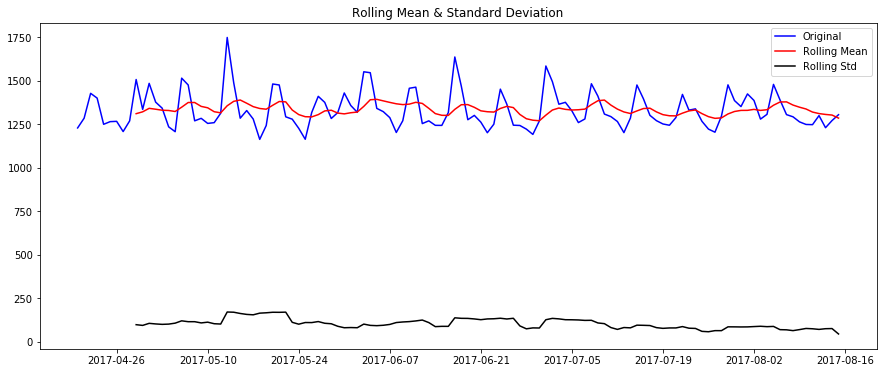

Results of Dickey-Fuller Test:
Test Statistic                  -2.438180
p-value                          0.131249
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [11]:
test_stationarity(ts)

In [12]:
ts_log = np.log(ts)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  """


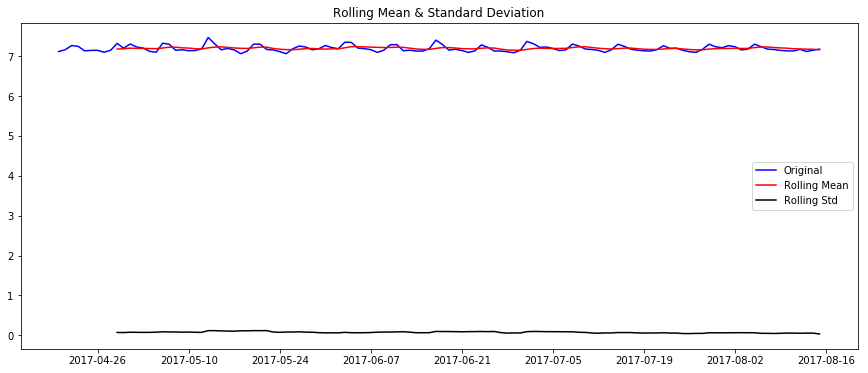

Results of Dickey-Fuller Test:
Test Statistic                  -2.508179
p-value                          0.113497
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [13]:
test_stationarity(ts_log)

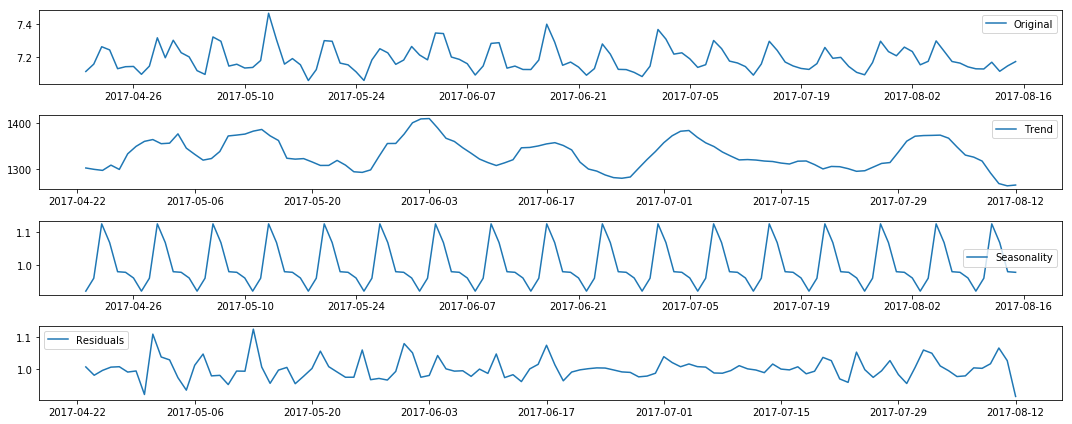

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts,model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

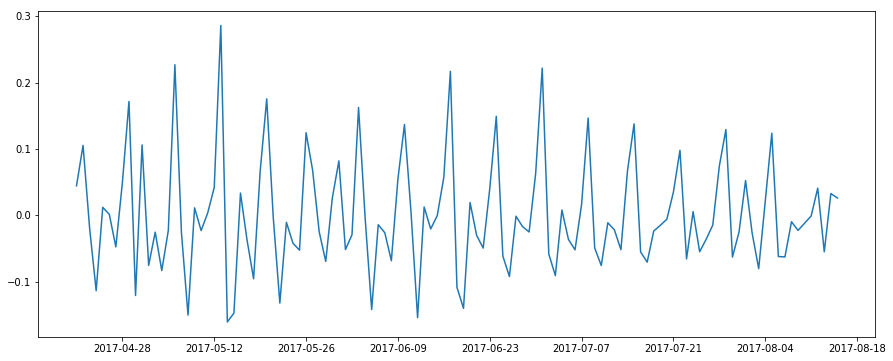

In [15]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  """


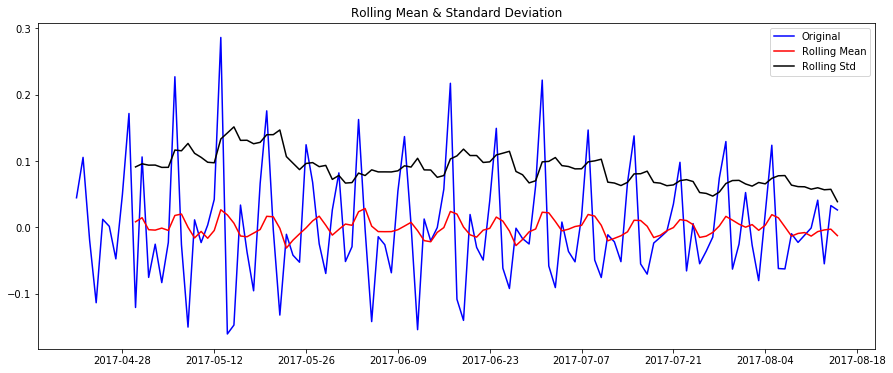

Results of Dickey-Fuller Test:
Test Statistic                -7.006284e+00
p-value                        7.108320e-10
#Lags Used                     1.200000e+01
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


In [16]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

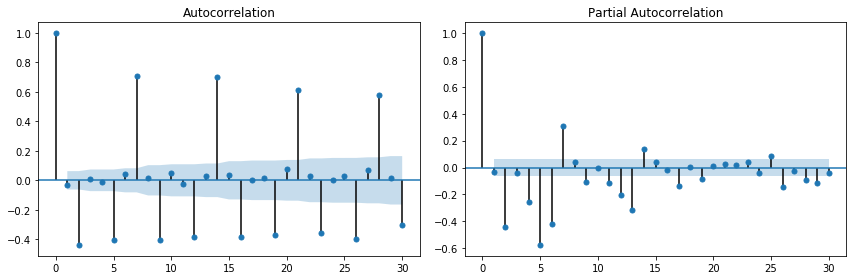

In [17]:
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

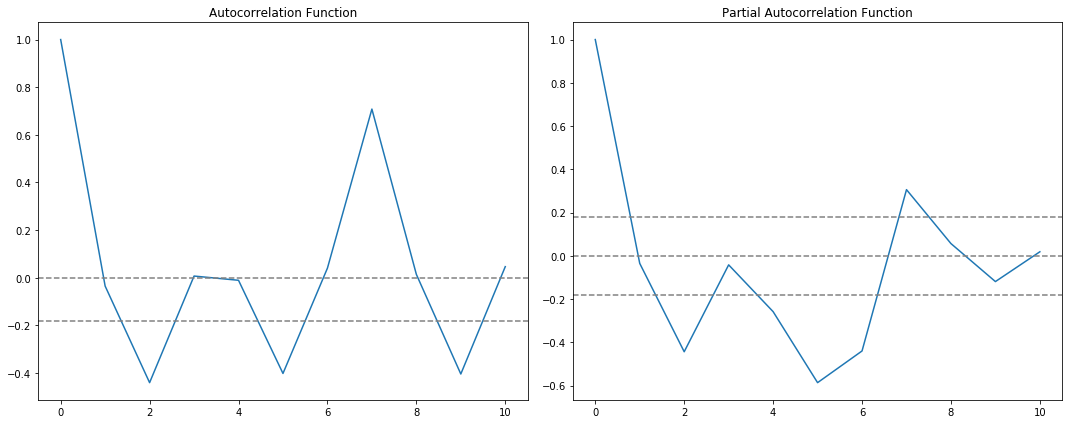

In [18]:
#ACF and PACF plots

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [19]:
#import warnings
#import itertools
#pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
#seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [20]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages

#for param in pdq:
 #   for param_seasonal in seasonal_pdq:
  #      try:
   #         mod1 = sm.tsa.statespace.SARIMAX(ts_log,
    #                                        order=param,
     #                                       seasonal_order=param_seasonal,
      #                                      enforce_stationarity=False,
       #                                     enforce_invertibility=False)
#
 #           results = mod1.fit()
#
 #           print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
  #      except:
   #         continue
#print("Best SARIMAX{}x{}7 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

In [21]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 0.5091')

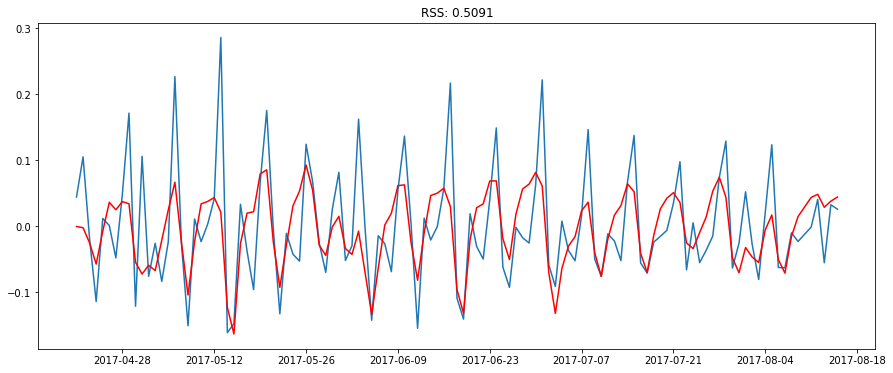

In [22]:
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)
plt.plot(ts_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [23]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 152.383
Method:                       css-mle   S.D. of innovations              0.064
Date:                Wed, 13 Dec 2017   AIC                           -294.765
Time:                        13:42:23   BIC                           -280.955
Sample:                    04-21-2017   HQIC                          -289.158
                         - 08-15-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.739      0.462      -0.001       0.000
ar.L1.D.y      0.5159      0.084      6.115      0.000       0.351       0.681
ar.L2.D.y     -0.4065      0.084     -4.849      0.0

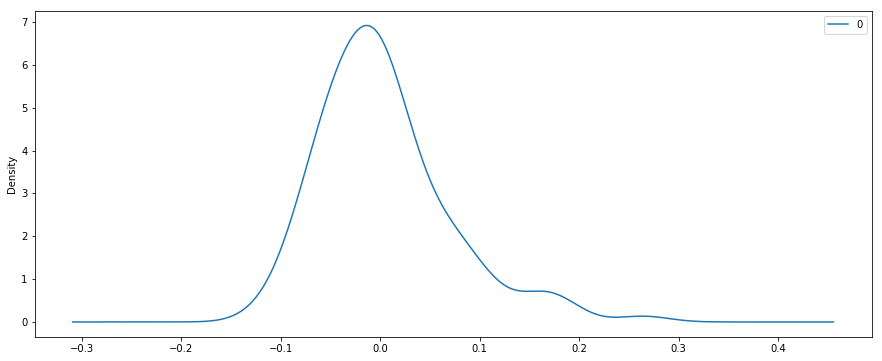

In [24]:
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')

In [25]:
print(residuals.describe())

                0
count  117.000000
mean     0.003791
std      0.066137
min     -0.117984
25%     -0.041293
50%     -0.007354
75%      0.031535
max      0.264456


In [26]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2017-04-21   -0.000146
2017-04-22   -0.001881
2017-04-23   -0.025158
2017-04-24   -0.057030
2017-04-25   -0.007324
dtype: float64


In [27]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)

In [28]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

In [29]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5,1,'RMSE: 493.0613')

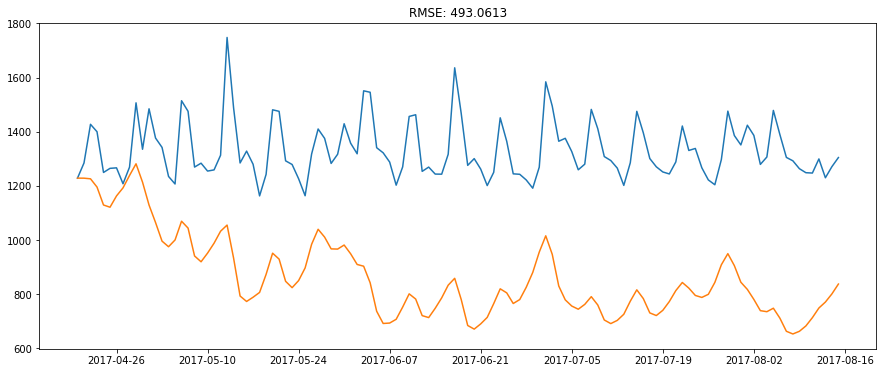

In [30]:
plt.plot(ts.index.to_pydatetime(), ts.values)
plt.plot(ts.index.to_pydatetime(), predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [31]:
expected=list(ts)

In [32]:
bias=[expected[i]-predictions_ARIMA_diff[i] for i in range(len(predictions_ARIMA_diff))]

In [33]:
mean_forcast_error=sum(bias)/len(bias)
print('Mean forcast error: %f' % mean_forcast_error)

Mean forcast error: 1331.051354


In [34]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected[1:], predictions_ARIMA_diff)
print('MAE: %f' % mae)

MAE: 1331.701283
